# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [3]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    data = pandas.read_csv(path_to_csv).values.tolist()
    random.shuffle(data)
    values = [num[1:] for num in data]
    answers = [1 if num[:1][0] == 'M' else 0 for num in data]
    return (values, answers)

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    data = pandas.read_csv(path_to_csv).values.tolist()
    random.shuffle(data)
    values = [num[:-1] for num in data]
    answers = [num[-1:] for num in data]
    return (values, answers)

In [204]:
read_cancer_dataset("cancer.csv")[0][:4]

[[10.49,
  19.29,
  67.41,
  336.1,
  0.09989,
  0.08578,
  0.02995,
  0.01201,
  0.2217,
  0.06481,
  0.355,
  1.534,
  2.302,
  23.13,
  0.007595,
  0.02219,
  0.0288,
  0.008614,
  0.0271,
  0.003451,
  11.54,
  23.31,
  74.22,
  402.8,
  0.1219,
  0.1486,
  0.07987,
  0.03203,
  0.2826,
  0.07552],
 [18.08,
  21.84,
  117.4,
  1024.0,
  0.07371,
  0.08642,
  0.1103,
  0.05778,
  0.177,
  0.0534,
  0.6362,
  1.305,
  4.312,
  76.36,
  0.00553,
  0.05296,
  0.0611,
  0.01444,
  0.0214,
  0.005036,
  19.76,
  24.7,
  129.1,
  1228.0,
  0.08822,
  0.1963,
  0.2535,
  0.09181,
  0.2369,
  0.06558],
 [9.777,
  16.99,
  62.5,
  290.2,
  0.1037,
  0.08404,
  0.04334,
  0.01778,
  0.1584,
  0.07065,
  0.403,
  1.424,
  2.747,
  22.87,
  0.01385,
  0.02932,
  0.02722,
  0.01023,
  0.03281,
  0.004638,
  11.05,
  21.47,
  71.68,
  367.0,
  0.1467,
  0.1765,
  0.13,
  0.05334,
  0.2533,
  0.08468],
 [17.6,
  23.33,
  119.0,
  980.5,
  0.09289,
  0.2004,
  0.2136,
  0.1002,
  0.1696,
  0.07369,

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [177]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    assert len(X) == len(y)
    del_ = (int) (len(X) * ratio)
    return (np.array(X[:del_]), np.array(y[:del_]), np.array(X[del_:]), np.array(y[del_:]))

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [196]:
def helper(x: float, y:float) -> float:
    if x + y == 0:
        return 1
    return (x / (x + y))

def calc_precisions(y_pred: np.array, y_true: np.array, classes: np.array
                    ) -> np.array:
    presicions = []
    for class_ in classes:
        correct_predictions_number = 0
        wrong_predictions_number = 0
        for i in range(0, len(y_true)):
            if y_pred[i] != class_:
                continue
            if y_true[i] == class_:
                correct_predictions_number += 1
            else:
                wrong_predictions_number += 1
        presicions.append(helper(correct_predictions_number, wrong_predictions_number))
    return np.array(presicions)


def calc_recalls(y_pred: np.array, y_true: np.array, classes: np.array
                ) -> np.array:
    recalls = []
    for class_ in classes:
        correct_predictions_number = 0
        wrong_predictions_number = 0
        for i in range(0, len(y_true)):
            if y_true[i] != class_:
                continue
            if y_pred[i] == class_:
                correct_predictions_number += 1
            else:
                wrong_predictions_number += 1
        recalls.append(helper(correct_predictions_number, wrong_predictions_number))
    return np.array(recalls)


def calc_accuracy(y_pred: np.array, y_true: np.array, classes: np.array
                ) -> float:
    correct_predictions_number :float = 0
    for i in range(0, len(y_true)):
        if y_pred[i] == y_true[i]:
            correct_predictions_number += 1
    return (correct_predictions_number) / (float) (len(y_true))

            
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    assert len(y_pred) == len(y_true)
    classes = np.unique(list(y_pred) + list(y_true))
    precisions = calc_precisions(y_pred, y_true, classes)
    recalls = calc_recalls(y_pred, y_true, classes)
    accuracy = calc_accuracy(y_pred, y_true, classes)
    return (precisions, recalls, accuracy)

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [155]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [146]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [114]:
def find_median(points: np.array, coordinate: int):
    assert len(points) > 0
    assert len(points[0][0]) > coordinate
    points_by_coordinate = [point[0][coordinate] for point in points]
    points_by_coordinate.sort()
    middle = int(len(points_by_coordinate) / 2)
    return points_by_coordinate[middle]


def split_by_median(points: np.array, median: float, coordinate: int):
    left = []
    right = []
    for point in points:
        if point[0][coordinate] < median:
            left.append(point)
        else:
            right.append(point)
    return left, right


def split_by_coordinate(points: np.array, coordinate: int):
    median = find_median(points, coordinate)
    left, right = split_by_median(points, median, coordinate)
    if len(left) == 0 or len(right) == 0:
        return None
    return left, right, median


def merge(neighbours, another_points, k):
    left = 0
    right = 0
    res = []
    for i in range(0, k):
        if left >= len(neighbours) and right >= len(another_points):
            return res
        if left >= len(neighbours):
            res.append(another_points[right])
            right += 1
            continue
        if right >= len(another_points):
            res.append(neighbours[left])
            left += 1
            continue
        if neighbours[left][1] <= another_points[right][1]:
            res.append(neighbours[left])
            left += 1
        else:
            res.append(another_points[right])
            right += 1
    return res


class KDTree:
    points_amount = None

    root = None

    coordinates_number = None

    def __build__(self, points: np.array, leaf_size: int, coordinate: int):
        if len(points) < 2 * leaf_size:
            return {
                'is_leaf': True,
                'points': points,
            }
        for i in range(0, self.coordinates_number):
            result = split_by_coordinate(points, (coordinate + i) % self.coordinates_number)
            if result is not None:
                return {
                    'is_leaf': False,
                    'points': points,
                    'left': self.__build__(result[0], leaf_size, (coordinate + i + 1) % self.coordinates_number),
                    'right': self.__build__(result[1], leaf_size, (coordinate + i + 1) % self.coordinates_number),
                    'median': result[2],
                    'coordinate': (coordinate + i) % self.coordinates_number,
                }
        return {
            'is_leaf': True,
            'points': points,
        }

    def __init__(self, X: np.array, leaf_size: int = 40):
        points_amount = len(X)
        assert points_amount > 0
        self.coordinates_number = len(X[0])
        points = [(x, i) for i, x in enumerate(X)]
        self.root = self.__build__(points, leaf_size, 0)

    def __find_nearest_neighbours__(self, point: np.array, k: int, root, neighbours):
        if root['is_leaf']:
            points = root['points']
            points = [(p, np.sum((point - p[0]) ** 2)) for p in points]
            points.sort(key=lambda x: x[1])
            neighbours[:] = points[:k]
            return

        median = root['median']
        coordinate = root['coordinate']
        if point[coordinate] < median:
            self.__find_nearest_neighbours__(point, k, root['left'], neighbours)
        else:
            self.__find_nearest_neighbours__(point, k, root['right'], neighbours)

        assert len(neighbours) > 0
        max_distance = neighbours[-1][1]
        if len(neighbours) == k and max_distance <= abs(median - point[coordinate]):
            return
        another_points = root['right']['points'] if point[coordinate] < median else root['left']['points']
        another_points = [(p, np.sum((point - p[0]) ** 2)) for p in another_points]
        another_points.sort(key=lambda x: x[1])
        another_points = another_points[:k]
        neighbours[:] = merge(neighbours, another_points, k)

    def query(self, X: np.array, k: int = 1) -> List[List]:
        result = []
        for point in X:
            neighbours = []
            self.__find_nearest_neighbours__(point, k, self.root, neighbours)
            result.append([neighbour[0][1] for neighbour in neighbours])
        return result

def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result


Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [139]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)
if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [192]:
import numpy as np
from typing import List


class KNearest:
    k = None
    leaf_size = None
    tree = None
    classes = None
    point_to_class_table = {}

    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        self.k = n_neighbors
        self.leaf_size = leaf_size

    def fit(self, X: np.array, y: np.array) -> NoReturn:
        self.classes = np.unique(list(y))
        self.tree = KDTree(X, leaf_size=self.leaf_size)
        for index, x in enumerate(X):
            self.point_to_class_table[index] = y[index]

    def predict_proba(self, X: np.array) -> List[np.array]:
        result = self.tree.query(X, self.k)
        answer = []
        for x_res in result:
            prediction_for_x = []
            for class_ in self.classes:
                class_count = 0
                for neighbour in x_res:
                    if self.point_to_class_table[neighbour] == class_:
                        class_count += 1
                prediction_for_x.append(class_count / float(self.k))
            answer.append(np.array(prediction_for_x))
        return result

    def predict(self, X: np.array) -> np.array:
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

[0 0 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0
 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1
 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0
 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0
 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 0 1
 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 1
 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0
 0 1 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 0 0 1 0 0
 0 1 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 0 1 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 1
 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 0 0 0 0 1 0 0
 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0
 0 0 0 1 1 0 1 1 0 1 0 0 

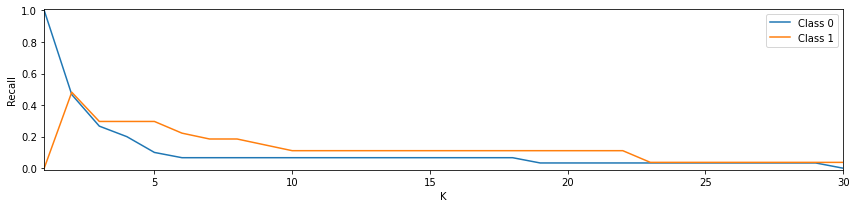

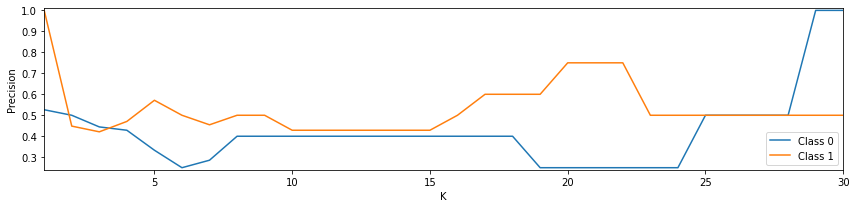

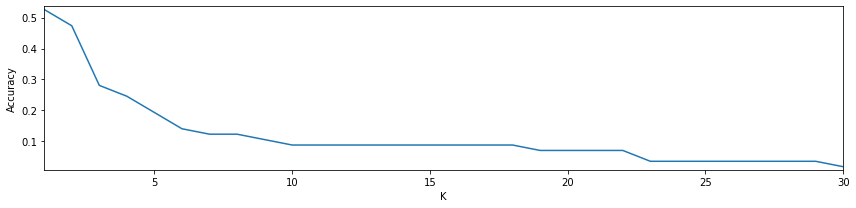

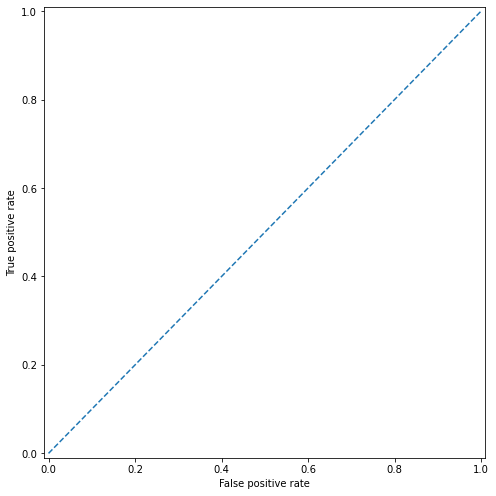

In [197]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [1.]] [[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.

/home/danielgabitov/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


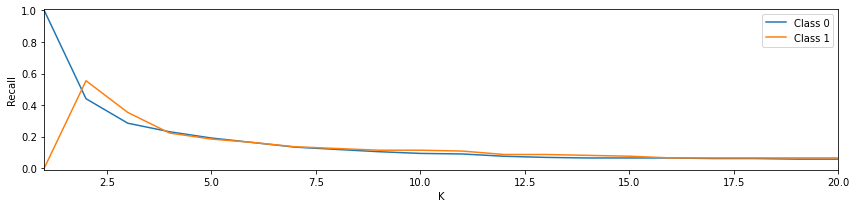

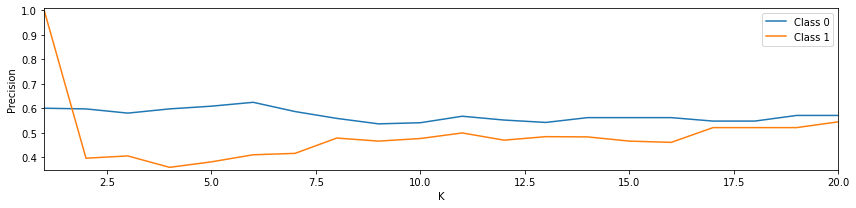

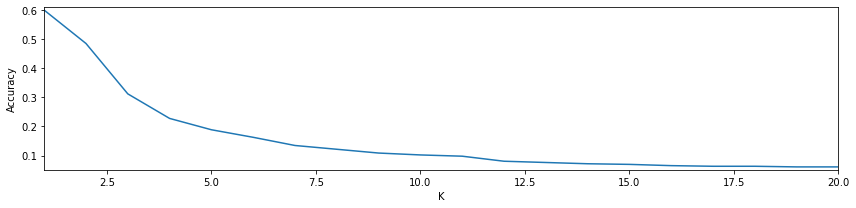

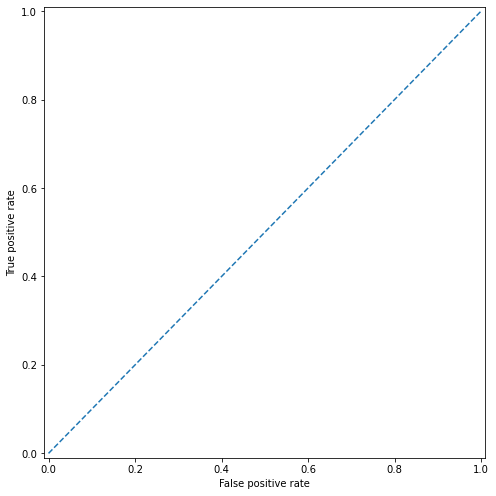

In [198]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)